# Casa Grande Aerial Preprocessing

This notebook presents a processing pipeline for downloading, organizing, and preprocessing historical aerial photographs acquired over **Casa Grande, Arizona**, on **1978-09-06**.  
The dataset consists of **37 aerial frames**, which will be prepared for subsequent photogrammetric and remote sensing analyses.  

The pipeline is structured into three main stages:

---

## 1. Data acquisition and preparation  

The majority of the data are retrieved using [usgsxplore](https://github.com/adehecq/usgs_explorer), which requires valid USGS credentials. The following products are generated or extracted during this step:

- **`images_footprint.geojson`**  
  Geospatial footprints of the images and associated metadata (downloaded via *usgsxplore*).  

- **`camera_model_extrinsics.csv`**  
  Camera orientation and acquisition information extracted from the metadata in `images_footprint.geojson`.  

- **`raw_images/*.tif`**  
  Original aerial photographs, stored as GeoTIFF files with LZW compression (downloaded via *usgsxplore*). NOTE : we rotate of 180° all images to match with the calibration report orientation.

- **`calibration_report.pdf`**  
  Camera calibration report describing internal orientation parameters and fiducial information.  
  *Note:* This file is not available for the present dataset via *usgsxplore* and would have to be retrieved manually if needed. However, the essential fiducial information is explicitly documented within this notebook, so the absence of the calibration report does not impede the workflow.  

- **`camera_model_intrinsics.csv`**  
  Internal camera model parameters, including fiducial marker positions (constructed from calibration report information when available).  

---

## 2. Detection of fiducial markers  

Fiducial detection is performed in a **semi-automated** manner using template matching:  

- A single set of templates (one for the four corners, one for the four midsides) is defined manually.  
- These templates are then applied consistently across the full batch of images.  
- Detection results are stored as image coordinates, and diagnostic plots are generated to visually assess detection accuracy and robustness.  

---

## 3. Image rectification using fiducial coordinates  

In this step, each image is geometrically corrected using the detected fiducials:  

- An affine transformation aligns the detected fiducials with the reference fiducials provided in `camera_model_intrinsics.csv`.  
- Images are warped accordingly, cropped around the fiducial center, and enhanced using **CLAHE** (Contrast Limited Adaptive Histogram Equalization).  
- For quality control, an additional set of images is produced using only cropping (without affine correction) to allow visual comparison of both processing strategies.  
- QC plots are generated to evaluate the transformation accuracy.  

---

## Project file structure  

The processing pipeline produces the following directory layout:  

```text
Project/
│
├── calibration_report.pdf          # Camera calibration report (if available)
├── camera_model_extrinsics.csv     # Camera orientation and acquisition metadata
├── camera_model_intrinsics.csv     # Internal camera parameters and fiducial definitions
├── images_footprint.geojson        # Image footprints and metadata from USGS
│
├── raw_images/                     # Original aerial photographs (GeoTIFF, LZW compressed)
│
├── preprocessed_images/            # Fiducial-aligned and contrast-enhanced images
│
├── cropped_images/                 # Cropped-only images (without affine correction)
│
├── qc/                             # Quality control plots of fiducial detection & alignment
│
└── fiducial_templates/             # Templates used for semi-automatic fiducial detection
```

Each images directory follow this structure :

```text
images_dir/
│
├── detected_fiducial_markers.csv   # Coordinates of detected fiducials in image reference system
│
├── image_id1.tif
├── image_id2.tif
│   ...
│
└── quickviews/                     # Low-resolution JPEG previews for visual inspection
    ├── image_id1.jpg
    ├── image_id2.jpg
    └── ...
```


This pipeline provides a systematic and reproducible framework for handling historical aerial imagery, enabling accurate use of fiducial information for geometric correction and preparing the data for further photogrammetric or geospatial analyses

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hipp
import usgsxplore
import os
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np

## Settings

In [3]:
paths: dict[str, Path] = {}
dir = Path("/mnt/summer/USERS/DEHECQA/history/data_prep/casa_grande/aerial_images/1978_09_06")
paths["dir"] = dir

paths["raw_images"] = dir / "raw_images"
paths["preproc_images"] = dir / "preprocessed_images"
paths["crop_images"] = dir / "cropped_images"
paths["fiducial_templates"] = dir / "fiducial_templates"
paths["qc"] = dir / "qc"
paths["detected_fiducials"] = paths["raw_images"] / "detected_fiducial_markers.csv"
paths["tf_detected_fiducials"] = paths["preproc_images"] / "detected_fiducial_markers.csv"
paths["crop_detected_fiducials"] = paths["crop_images"] / "detected_fiducial_markers.csv"
paths["intrinsics"] = dir / "camera_model_intrinsics.csv"
paths["extrinsics"] = dir / "camera_model_extrinsics.csv"
paths["footprint"] = dir / "images_footprint.geojson"
paths["dir"] = dir

# others settings
QUICKVIEWS_FACTOR = 0.2
MAX_WORKERS = 4
OVERWRITE = False

## Downloading the dataset

In [ ]:
DS_METADATA = {
    "dataset":"aerial_combin",
    "bbox": [-111.87783, 32.66157, -111.60280, 32.89378],
    "date_interval": ("1978-09-06", "1978-09-06"),
    "meta_filter": "HIGH_AVAILABLE=Yes"
}
PRODUCT_NUMBER = 1 # 0: medium res, 1: high res, 2: calibration report

if not paths["raw_images"].exists() or OVERWRITE:
    # connect to the API, download raw images and logout
    username = os.getenv("USGS_USERNAME") or input("Enter your USGS username: ")
    token = os.getenv("USGS_TOKEN") or input("Enter your USGS token: ")
    api = usgsxplore.API(username, token)

    # search all metadatas
    scenes_metadata = api.search(**DS_METADATA)

    # Save footprints and metadatas in a geojson
    usgsxplore.utils.convert_response_to_gdf(scenes_metadata).to_file(paths["footprint"], driver="GeoJSON")

    # Process metadata to save the extrinsics file
    df = usgsxplore.utils.convert_response_to_df(scenes_metadata)
    df["image_file_name"] = df["Entity  ID"].apply(lambda txt: f"{txt}.tif")
    df["lat"] = df["Center Latitude dec"]
    df["lon"] = df["Center Longitude dec"]
    df["alt"] = df["Flying Height in Feet"].apply(lambda x: x * 0.3048) # convert feat in meters
    df[["image_file_name", "lon", "lat", "alt"]].to_csv(paths["extrinsics"], index=False)

    # get the list of entity ids
    entity_ids = df["Entity  ID"].tolist()

    # Download all images with the good product code and from their entity ids
    api.download("aerial_combin", entity_ids, product_number=PRODUCT_NUMBER, output_dir=paths["raw_images"], max_workers=MAX_WORKERS)

    # download the calibration report (the calibration does not exist so we comment it to avoid an error)
    #api.download_calibration_report("aerial_combin", entity_ids[0], paths["dir"])

    # logout from the api
    api.logout()

    # rotate all tif images of 180° to align them with the calibration report 
    for raster_path in tqdm(list(paths["raw_images"].glob("*.tif")), desc="Rotate images"):
        with rasterio.open(raster_path, "r+") as src:
            data = src.read() # shape (bands, H, W)
            src.write(np.rot90(data, 2, axes=(1, 2))) # rotate only spatial dims

    # generate quick views from raw images
    hipp.tools.generate_quickviews(paths["raw_images"], QUICKVIEWS_FACTOR, max_workers=MAX_WORKERS, overwrite=OVERWRITE)

## Creating the camera model intrinsics file

To create the `camera_model_intrinscis.csv` file we wile look at the calibration report. 
!IMPORTANT! we have previously rotate the image to match the calibration report orientation.



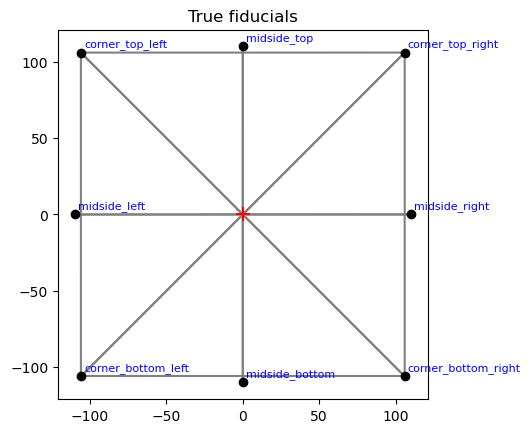

In [4]:
focal_length = 152.865
pixel_pitch = 0.025

fiducial_coords = [
    (-105.983, -106.005),
    (105.996, 106.006),
    (-105.998, 105.985),
    (106.001, -106.005),
    (-110.004, -0.009),
    (110.013, 0.024),
    (-0.003, 109.999),
    (0.009, -109.992),
    (-0.030, -0.001) # ppa
]
intrinsics = hipp.Intrinsics.from_list(focal_length, pixel_pitch, fiducial_coords)
intrinsics.to_csv(paths["intrinsics"])
hipp.aerial.qc.plot_true_fiducials(intrinsics.true_fiducials_mm)

## Fiducial templates creation

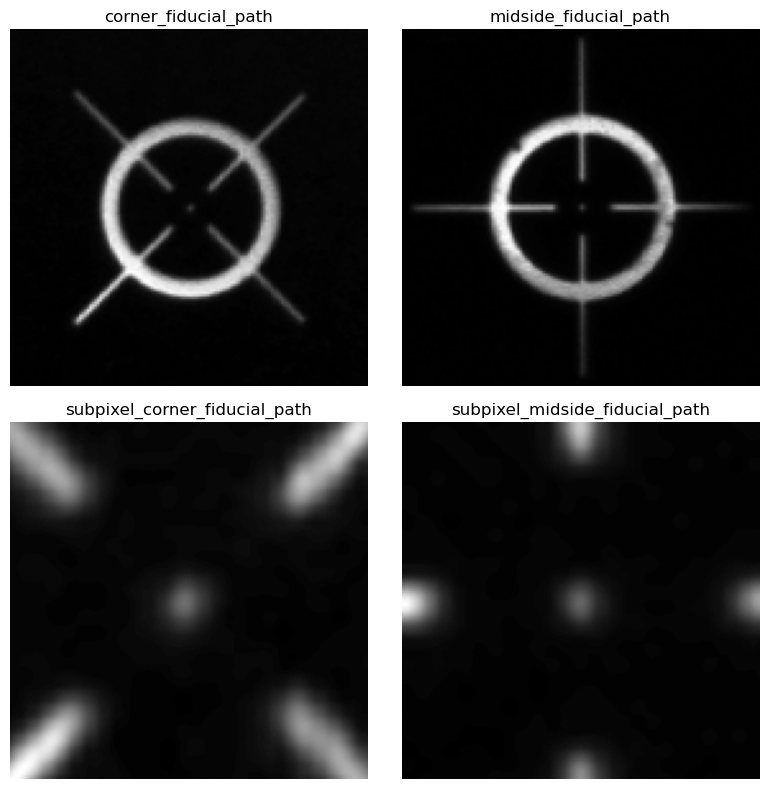

In [5]:
first_image_path = sorted(paths["raw_images"].glob("*.tif"))[0]  
saved_coords_midside = {'fiducial_coordinate': (1083, 5165), 'subpixel_center_coordinate': (564, 560)}
saved_coords_corner = {'fiducial_coordinate': (9761, 886), 'subpixel_center_coordinate': (567, 562)}

_ = hipp.aerial.create_fiducial_templates(first_image_path, paths["fiducial_templates"], midside=True, distance_around_fiducial=70, **saved_coords_midside) 
_ = hipp.aerial.create_fiducial_templates(first_image_path, paths["fiducial_templates"], corner=True, distance_around_fiducial=70, **saved_coords_corner)
hipp.aerial.qc.plot_fiducial_templates(paths["fiducial_templates"])

## Fiducials detection

Fiducial detections: 100%|████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:18<00:00,  1.95Image/s]


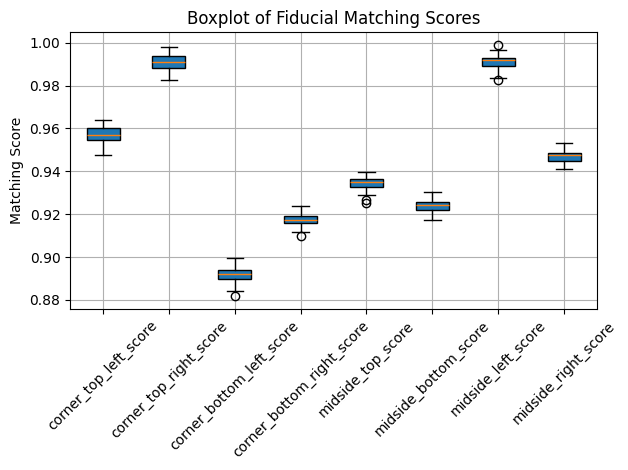

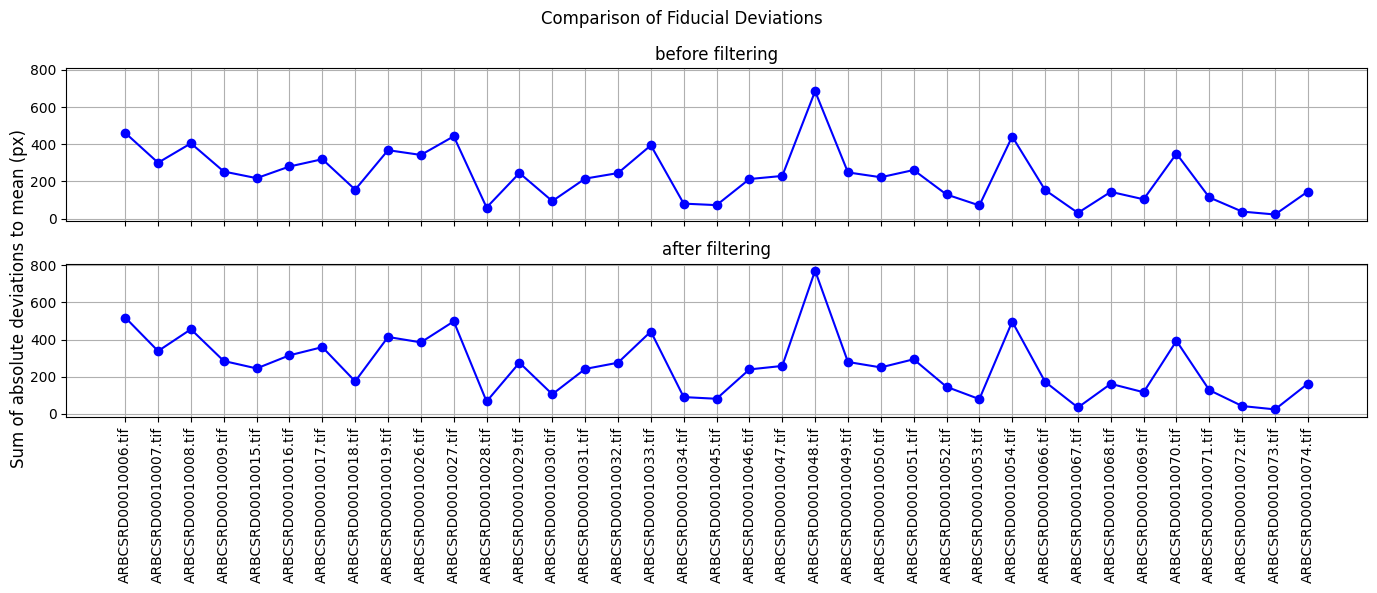

In [38]:
detected_fiducials_df = hipp.aerial.iter_detect_fiducials(paths["raw_images"], paths["fiducial_templates"], grid_size=7, max_workers=MAX_WORKERS)

# filter detection and save them into a csv
filtered_detected_fiducials_df = hipp.aerial.filter_detected_fiducials(detected_fiducials_df)
filtered_detected_fiducials_df.round(2).to_csv(paths["detected_fiducials"])

# plot matching score
output_plot_path = paths["qc"] / "detection_score_boxplot.png"
hipp.aerial.qc.plot_detection_score_boxplot(detected_fiducials_df, show=True, output_plot_path=output_plot_path)

# plot fiducials filtering
output_plot_path = paths["qc"] / "fiducials_filtering.png"
hipp.aerial.qc.plot_fiducials_filtering(detected_fiducials_df,filtered_detected_fiducials_df, show=True, output_plot_path=output_plot_path)

# plot individuals detection
output_dir = paths["qc"] / "individual_detections"
hipp.aerial.qc.generate_detection_qc_plots(paths["raw_images"], detected_fiducials_df, output_dir)

## Compute Affine transformations


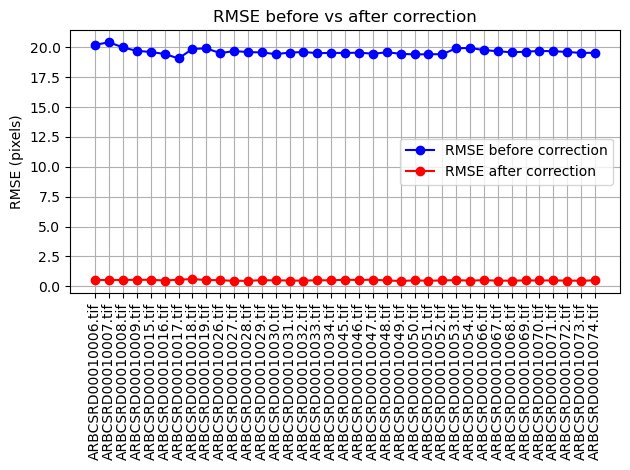

In [7]:
# open intrinsics
intrinsics = hipp.Intrinsics.from_csv(paths["intrinsics"])

# here we take result image of 9 inchs (228.6 mm) because it's the size of aerial images
# we minus 5 px to be avoid some black borders
# can be apply with 208 mm to have no artifacts
image_square_dim = int(228.6 / intrinsics.pixel_pitch) - 5 
df = pd.read_csv(paths["detected_fiducials"], index_col="image_id")

transformations = hipp.aerial.compute_transformations(df, intrinsics.true_fiducials_mm, image_square_dim, intrinsics.pixel_pitch)

# save the transformed detected fiducial markers (coordinate of fiducials in preprocessed images)
paths["tf_detected_fiducials"].parent.mkdir(parents=True, exist_ok=True)
hipp.aerial.warp_fiducials_df(df, transformations).round(2).to_csv(paths["tf_detected_fiducials"])

# plot the correction to ensure it's correct
hipp.aerial.qc.plot_fiducials_correction(df, transformations, intrinsics.true_fiducials_mm, intrinsics.pixel_pitch)

## Warp images

In [31]:
hipp.aerial.iter_image_restitution(
    paths["raw_images"], 
    paths["preproc_images"], 
    transformations,
    image_square_dim=image_square_dim,
    max_workers=MAX_WORKERS,
    overwrite=OVERWRITE
)
hipp.tools.generate_quickviews(paths["preproc_images"], factor=QUICKVIEWS_FACTOR, max_workers=MAX_WORKERS)

Generating quickviews: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:17<00:00,  2.12image/s]


## Preprocessed with only crop around the center of fiducials

In [11]:
intrinsics = hipp.Intrinsics.from_csv(paths["intrinsics"])


image_square_dim = int(228.6 / intrinsics.pixel_pitch) - 5 
df = pd.read_csv(paths["detected_fiducials"], index_col="image_id")

# we set true_fiducials_mm to None to keep only the translation for the cropping
crop_tfs = hipp.aerial.compute_transformations(df, None, image_square_dim, intrinsics.pixel_pitch)

# save the transformed detected fiducial markers (coordinate of fiducials in preprocessed images)
paths["crop_detected_fiducials"].parent.mkdir(exist_ok=True, parents=True)
hipp.aerial.warp_fiducials_df(df, crop_tfs).round(2).to_csv(paths["crop_detected_fiducials"])

hipp.aerial.iter_image_restitution(
    paths["raw_images"], 
    paths["crop_images"], 
    crop_tfs,
    image_square_dim=image_square_dim,
    max_workers=MAX_WORKERS,
    overwrite=OVERWRITE
)
hipp.tools.generate_quickviews(paths["crop_images"], factor=QUICKVIEWS_FACTOR, max_workers=MAX_WORKERS)


0it [00:00, ?it/s]


## GCP

In [14]:
def read_gcp(file_path: str | Path) -> pd.DataFrame:
    """ Read a GCP (Ground Control Points) file in either .csv or .gcp format. """
    file_path = Path(file_path)
    if file_path.name.endswith(".csv"):
        return pd.read_csv(file_path)
    elif file_path.name.endswith(".gcp"):
        colonnes = [
            "gcp_label",         
            "image_file_name",        
            "x",       
            "y",    
            "x_map",
            "y_map"     
            "lon",            
            "lat",             
            "elev",      
            "lon_acc", "lat_acc", "elev_acc" 
        ]
        return pd.read_csv(file_path, sep=r"\s+", header=None, names=colonnes)
    else:
        raise ValueError(
            f"Unsupported file extension: '{file_path}'. "
            "Supported formats are .csv and .gcp"
        )
    
def transform_gcp(gcp_df: pd.DataFrame, transformation_matrixs) -> pd.DataFrame:
    """Apply geometric transformation to the GCP pixel coordinates (x, y)
    using the corresponding transformation matrix for each image."""

    def apply_affine(row):
        transform = transformation_matrixs[row["image_file_name"]]
        x, y = hipp.math.transform_coord((row["x"], row["y"]), transform)
        return pd.Series({"x": x, "y": y})

    transformed_df = gcp_df.copy()
    transformed_df[["x", "y"]] = transformed_df.apply(apply_affine, axis=1).round(2)

    return transformed_df

# open raw gcp and transform it to have gcp in every geometry
raw_gcp = read_gcp(paths["raw_images"] / "gcp.csv")
preprocesses_gcp = transform_gcp(raw_gcp, transformations)
cropped_gcp = transform_gcp(raw_gcp, crop_tfs)

# save the gcp 
preprocesses_gcp.to_csv(paths["preproc_images"] / "gcp.csv", index=False)
cropped_gcp.to_csv(paths["crop_images"] / "gcp.csv", index=False)

